<a href="https://colab.research.google.com/github/rahiakela/mlops-research-and-practice/blob/main/MLOps-Specialization/course-3-machine-learning-modeling-pipelines-in-production/week-2-model-resource-management-techniques/02_algorithmic_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Algorithmic Dimensionality Reduction 

Welcome, during this ungraded lab you are going to perform several algorithms that aim to reduce the dimensionality of data. This topic is very important because it is not uncommon that reduced models outperform the ones trained on the raw data because noise and redundant information are present in most datasets. This will also allow your models to train and make predictions faster, which might be really important depending on the problem you are working on. In particular you will:


1. Use Principal Component Analysis (**PCA**) to reduce the dimensionality of a dataset that classifies celestial bodies.
2. Use Single Value Decomposition (**SVD**) to create low level representations of images of handwritten digits.
3. Use Non-negative Matrix Factorization (**NMF**) to segment text into topics.

Let's get started!

##Setup

In [1]:
# General use imports
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.datasets import load_digits
from sklearn.datasets import fetch_20newsgroups

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Download zip file
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip -o HTRU2.zip

# Unzip it
data_folder = os.path.join('.', 'data')
import zipfile
with zipfile.ZipFile('HTRU2.zip', 'r') as zip_ref:
    zip_ref.extractall(data_folder)
    
# Delete the downloaded zip file
os.remove('HTRU2.zip')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1526k  100 1526k    0     0  2291k      0 --:--:-- --:--:-- --:--:-- 2288k


In [3]:
os.listdir(data_folder)

['HTRU_2.csv', 'HTRU_2.arff', 'Readme.txt']

## Principal Components Analysis - PCA

This is an unsupervised algorithm that creates linear combinations of the original features. PCA is a widely used technique for dimension reduction since it is fast and easy to implement. PCA aims to keep as much variance as possible from the original data in a lower dimensional space. It finds the best axis to project the data so that the variance of the projections is maximized.

In the lecture you saw PCA applied to the Iris dataset. This dataset has been used extensively to showcase PCA so here you are going to do something different. You are going to use the [HTRU_2](https://archive.ics.uci.edu/ml/datasets/HTRU2) dataset which describes several celestial objects and the idea is to be able to classify if an object is a pulsar star or not.


Load the data into a dataframe for easier inspection:

In [4]:
# Load data into a pandas dataframe
data = pd.read_csv(os.path.join(data_folder, "HTRU_2.csv"), names=["mean_ip", "sd_ip", "ec_ip", "sw_ip", "mean_dm", "sd_dm", "ec_dm", "sw_dm", "pulsar"])
data.head()

,mean_ip,sd_ip,ec_ip,sw_ip,mean_dm,sd_dm,ec_dm,sw_dm,pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


This dataset has 8 numerical features (the "pulsar" column is the label). Now you are going to perform PCA reduce this 8th-dimensional input space to a lower dimensional one.

But first, scale the data. If you do an exploratory analysis of the data you will see that this dataset has a lot of outliers. Because of this you are going to use a [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), which scales features using statistics that are robust to outliers.

In [5]:
# Split features from labels
features = data[[col for col in data.columns if col != "pulsar"]]
labels = data["pulsar"]

# Scale data (robust_data is a numpy array)
robust_data = RobustScaler().fit_transform(features)

In [6]:
features.head()

,mean_ip,sd_ip,ec_ip,sw_ip,mean_dm,sd_dm,ec_dm,sw_dm
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306


In [7]:
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: pulsar, dtype: int64

(array([1.28215e+05, 1.34400e+04, 9.71000e+02, 3.26000e+02, 1.22000e+02,
        5.60000e+01, 2.50000e+01, 1.40000e+01, 6.00000e+00, 9.00000e+00]),
 array([  -3.13926961,  116.27474105,  235.68875171,  355.10276237,
         474.51677303,  593.93078369,  713.34479436,  832.75880502,
         952.17281568, 1071.58682634, 1191.000837  ]),
 <a list of 10 Patch objects>)

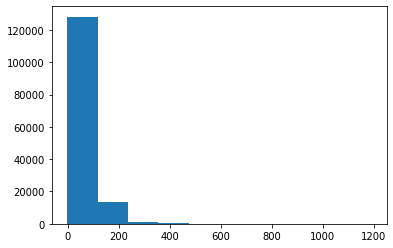

In [8]:
plt.hist(features.to_numpy().reshape(-1))

(array([1.32506e+05, 7.51900e+03, 1.24900e+03, 5.84000e+02, 4.73000e+02,
        3.96000e+02, 2.13000e+02, 1.49000e+02, 7.60000e+01, 1.90000e+01]),
 array([-4.70444619,  1.99528832,  8.69502283, 15.39475733, 22.09449184,
        28.79422635, 35.49396086, 42.19369537, 48.89342988, 55.59316439,
        62.29289889]),
 <a list of 10 Patch objects>)

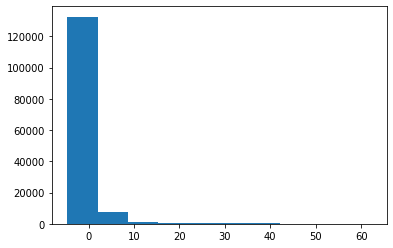

In [9]:
plt.hist(robust_data.reshape(-1))

Now perform PCA using sklearn. In this first iteration you are going to create a principal component for each one of the features so there is no dimensionality reduction:

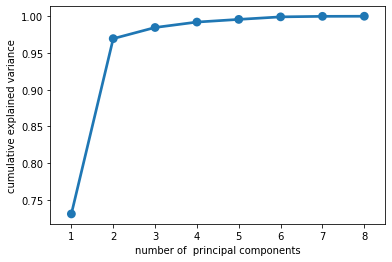

In [10]:
# Instantiate PCA without specifying number of components
pca_all = PCA()

# Fit to scaled data
pca_all.fit(robust_data)

# Save cumulative explained variance
cum_var = (np.cumsum(pca_all.explained_variance_ratio_))
n_comp = [i for i in range(1, pca_all.n_components_ + 1)]

# Plot cumulative variance
ax = sns.pointplot(x=n_comp, y=cum_var)
ax.set(xlabel="number of  principal components", ylabel="cumulative explained variance")
plt.show()

Wow! With just 3 components almost all of the variance of the original data is explained! This makes you think that there were some highly correlated features in the original data.

Let's plot the first 3 principal components:

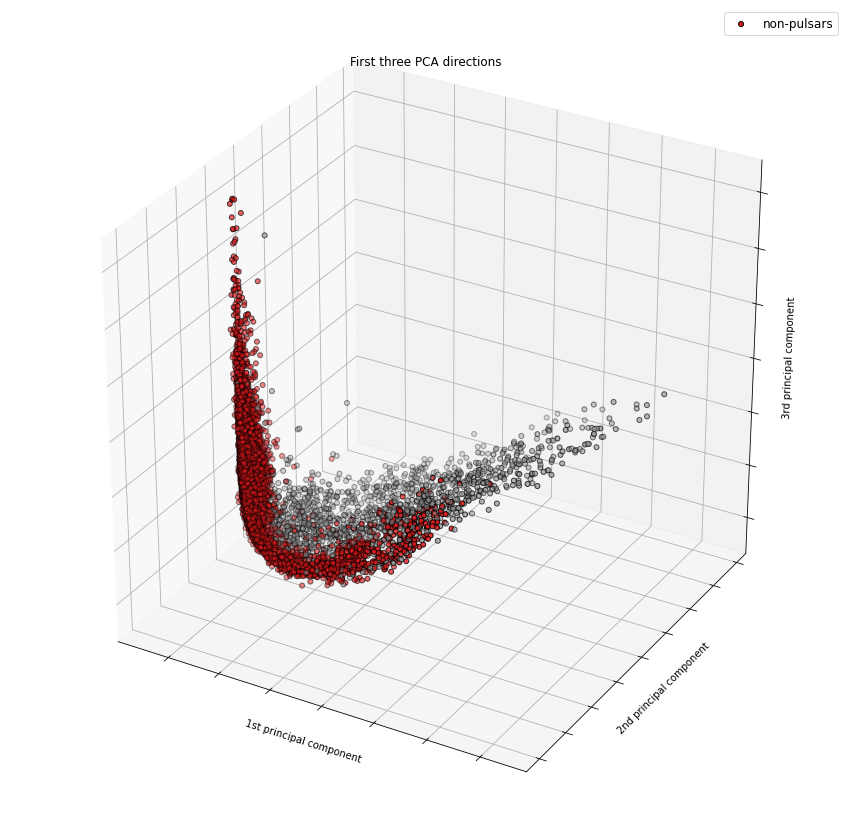

In [11]:
# Instantiate PCA with 3 components
pca_3 = PCA(3)

# Fit to scaled data
pca_3.fit(robust_data)

# Transform scaled data
data_3pca = pca_3.transform(robust_data)

#  Render the 3D plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_3pca[:, 0], data_3pca[:, 1], data_3pca[:, 2], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=25, label=data['pulsar'])

ax.legend(["non-pulsars"], fontsize="large")

ax.set_title("First three PCA directions")
ax.set_xlabel("1st principal component")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd principal component")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd principal component")
ax.w_zaxis.set_ticklabels([])

plt.show()

It is possible to visualize a plane that would be able to separate both classes since non-pulsars tend to group on the edge of this surface while pulsars are mostly located on the inner side of the surface.

In this case it is reasonable to think that the dimension can be reduced even more since with 2 principal components more than 95% of the variance of the original data is explained. Now let's plot just the first two principal components:

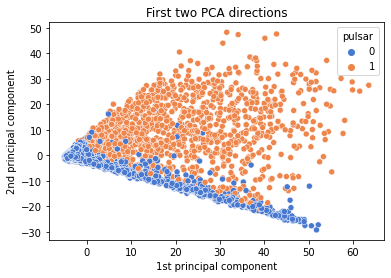

In [12]:
# Instantiate PCA with 2 components
pca_2 = PCA(2)

# Fit and transform scaled data
pca_2.fit(robust_data)
data_2pc = pca_2.transform(robust_data)

# Render the 2D plot
ax = sns.scatterplot(x=data_2pc[:,0], 
                     y=data_2pc[:,1], 
                     hue=labels,
                     palette=sns.color_palette("muted", n_colors=2))

ax.set(xlabel='1st principal component', ylabel='2nd principal component', title='First two PCA directions')
plt.show()

Even in 2D the 2 classes look linearly separable (not perfectly, of course) but this is quite remarkable considering that the initial space was 8th dimensional.

Using PCA you've successfully reduced the dimensionality from 8 to 2 while maintaining a lot of the variance of the original data!


## Singular Value Decomposition - SVD

SVD is one way to decompose matrices. Remember that matrices can be seen as linear transformations in space. PCA relies on eigendecomposition, which can only be done for square matrices. However you don’t always have square matrices, and sometimes you have really sparse matrices.

To decompose these types of matrices, which can’t be decomposed with eigendecomposition, you can use techniques such as Singular Value Decomposition. SVD decomposes the original dataset into its constituents, resulting in a reduction of dimensionality. It is used to remove redundant features from the dataset.

To check SVD you are going to use the [digits dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html), which is made up of 1797 8x8 images of handwritten digits:


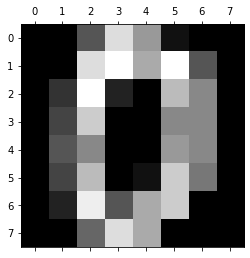

In [13]:
# Load the digits dataset
digits = load_digits()

# Plot first digit
image = digits.data[0].reshape((8, 8))
plt.matshow(image, cmap="gray")
plt.show()

You might think that since every digit is 8x8 this will be a square matrix and thus PCA might be a better choice. However, each digit is represented as a 1x64 array. Also you might wonder why the first example worked with PCA if the data had far more observations than features. The reason is that when performing PCA you end up using the matrix product $X^{t}X$ which is a square matrix.

The above is a consequence of the nature of the problems. The pulsar star dataset had numerical data to represent each data point. On the other hand, this dataset represents images through pixels.

Let's continue by normalizing the data and checking its dimensions:

In [14]:
# Save data into X variable
X = digits.data

# Normalize pixel values
X = X / 255

# Print shapes of dataset and data points
print(f"Digits data has shape {X.shape}\n")
print(f"Each data point has shape {X[0].shape}\n")

Digits data has shape (1797, 64)

Each data point has shape (64,)



Plot the first digit to check how normalization affects the images:

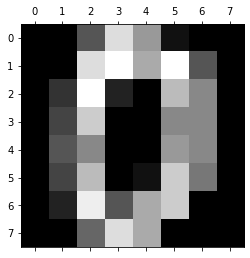

In [15]:
image = X[0].reshape((8, 8))
plt.matshow(image, cmap = 'gray')
plt.show()

The image should be identical to the one without normalization. This is because the relative brightness of each pixel with the others is maintained. Normalization is done as a preprocessing step when feeding the data into a Neural Network. Here it is done since it is a step that is usually always done when working with image data.

Now perform SVD on the data and plot the cumulative amount of explained variance for every number of components. 

Note that the [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) needs a number of components strictly lower to the number of features.

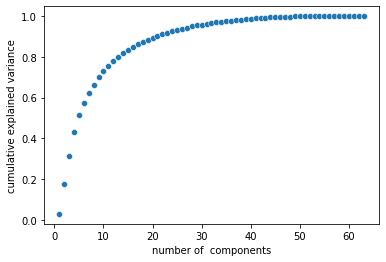

In [16]:
# Instantiate Truncated SVD with (original dimension - 1) components
org_dim = X.shape[1]
tsvd = TruncatedSVD(org_dim - 1)
tsvd.fit(X)

# Save cumulative explained variance
cum_var = (np.cumsum(tsvd.explained_variance_ratio_))
n_comp = [i for i in range(1, org_dim)]

# Plot cumulative variance
ax = sns.scatterplot(x=n_comp, y=cum_var)
ax.set(xlabel='number of  components', ylabel='cumulative explained variance')
plt.show()

Looking at the plot, it can be seen that with only 5 components near the 50% of the variance of the original data is explained.

Let's double check this:

In [17]:
print(f"Explained variance with 5 components: {float(cum_var[4:5])*100:.2f}%")

Explained variance with 5 components: 51.53%


It is not a lot but let's check what you get when performing SVD with only 5 components:

In [18]:
# Instantiate a Truncated SVD with 5 components
tsvd = TruncatedSVD(n_components=5)

# Get the transformed data
X_tsvd = tsvd.fit_transform(X)

# Print shapes of dataset and data points
print(f"Original data points have shape {X[0].shape}\n")
print(f"Transformed data points have shape {X_tsvd[0].shape}\n")

Original data points have shape (64,)

Transformed data points have shape (5,)



By doing this, you are now representing each digit using 5 dimensions instead of the original 64! Isn't that amazing?

Now check how this looks like visually:

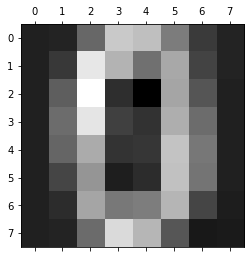

In [19]:
image_reduced_5 = tsvd.inverse_transform(X_tsvd[0].reshape(1, -1))
image_reduced_5 = image_reduced_5.reshape((8, 8))

plt.matshow(image_reduced_5, cmap="gray")
plt.show()

It looks blurry but you can still tell this is a zero.

### Using more components

Let’s try again, only, this time, we use half the number of features in the original data. 

But first define a function that performs this process for any number of components:

In [20]:
def image_given_components(n_components, verbose=True):
  tsvd = TruncatedSVD(n_components=n_components)
  X_tsvd = tsvd.fit_transform(X)
  if verbose:
    print(f"Explained variance with {n_components} components: {float(tsvd.explained_variance_ratio_.sum())*100:.2f}%\n")
  image = tsvd.inverse_transform(X_tsvd[0].reshape(1, -1))
  image = image.reshape((8, 8))
  return image

Use the function to generate the image that use 32 components:

Explained variance with 32 components: 96.63%



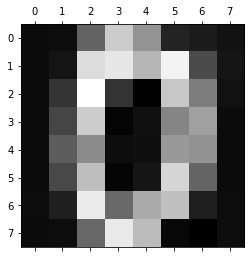

In [21]:
image_reduced_32 = image_given_components(32)

plt.matshow(image_reduced_32, cmap="gray")
plt.show()

Wow! This image looks very similar to the original one (no wonder since more than 95% of the original variance is explained) but the dimensionality of the representations have been cut in half!

To better grasp how the images look like depending on the dimensionality of the representations, the next cell plots them side by side (the last figure has a parameter that you can tweak):

Explained variance with 32 components: 96.63%

Explained variance with 5 components: 51.53%

Explained variance with 3 components: 31.37%

Explained variance with 1 components: 2.87%



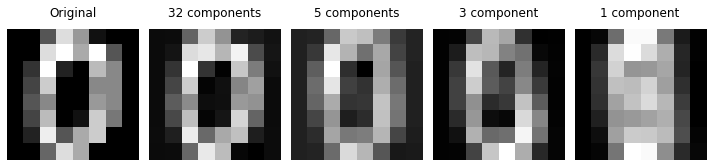

In [22]:
fig = plt.figure(figsize=(10, 5))

# Original image
ax1 = fig.add_subplot(1,5,1)
ax1.matshow(image, cmap = 'gray')
ax1.title.set_text('Original')
ax1.axis('off') 

# Using 32 components
ax2 = fig.add_subplot(1,5,2)
ax2.matshow(image_given_components(32), cmap = 'gray')
ax2.title.set_text('32 components')
ax2.axis('off') 

# Using 5 components
ax3 = fig.add_subplot(1,5,3)
ax3.matshow(image_given_components(5), cmap = 'gray')
ax3.title.set_text('5 components')
ax3.axis('off') 

# Using 3 components
ax4 = fig.add_subplot(1,5,4)
ax4.matshow(image_given_components(3), cmap = 'gray') # Change this parameter to see other representations
ax4.title.set_text('3 component')
ax4.axis('off')

# Using 1 components
ax5 = fig.add_subplot(1,5,5)
ax5.matshow(image_given_components(1), cmap = 'gray') # Change this parameter to see other representations
ax5.title.set_text('1 component')
ax5.axis('off')

plt.tight_layout()
plt.show()

Notice how with 1 component, it is not possible to determine that the image is a zero. What is the minimun number of components that are needed for this? Be sure to try out different values and see what you get!

Explained variance with 16 components: 84.80%



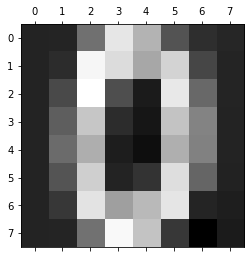

In [23]:
image_reduced_16 = image_given_components(16)

plt.matshow(image_reduced_16, cmap="gray")
plt.show()

## Non-negative Matrix Factorization - NMF

NMF expresses samples as combinations of interpretable parts. For example, it represents documents as combinations of topics, and images in terms of commonly occurring visual patterns. NMF, like PCA, is a dimensionality reduction technique. In contrast to PCA, however, NMF models are interpretable. This means NMF models are easier to understand and much easier for us to explain to others. NMF can't be applied to every dataset, however. It requires the sample features be non-negative, so greater than or equal to 0. 

To test NMF you will use the [20newsgroups dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) which comprises around 12000 newsgroups posts on 20 topics. 

In [24]:
# Download data
data = fetch_20newsgroups(remove=("headers", "footers", "quotes"))

# Get the actual text data from the sklearn Bunch
data = data.get("data")

In [25]:
type(data)

list

In [26]:
data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

At this point you have the data in a list format. Let's check it out:

In [27]:
print(f"Data has {len(data)} elements.\n")
print(f"First 2 elements: \n")
for n, d in enumerate(data[:2], start=1):
  print("="*60)
  print(f"Element number {n}:\n\n{d}\n")

Data has 11314 elements.

First 2 elements: 

Element number 1:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Element number 2:

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the networ

Notice that you only have the actual text without information of the topic it belongs to (labels). 

Now you need to represent the text as vectors, for this you will use a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) with `max_features` set to 500. This will be the original dimensionality of the data (which you will reduce via NMF).

In [28]:
# Instantiate vectorizer setting dimensionality of data
# The stop_words param refer to words (in english) that don't add much value to the content of the document and must be ommited
vectorizer = TfidfVectorizer(max_features=500, stop_words="english")

# Vectorize original data
vect_data = vectorizer.fit_transform(data)
print(f"Data type is {type(vect_data)}.")

# Print dimensionality
print(f"Data has shape {vect_data.shape} after vectorization.")
print(f"Each data point has shape {vect_data[0].shape} after vectorization.")

Data type is <class 'scipy.sparse.csr.csr_matrix'>.
Data has shape (11314, 500) after vectorization.
Each data point has shape (1, 500) after vectorization.


Every one of the texts in the original data is represented as a 1x500 vector.

Now use NMF to reduce this dimensionality:

In [30]:
# Desired number of components
n_comp = 5

# Instantiate NMF with the desired number of components
nmf = NMF(n_components=n_comp, random_state=42)

# Apply NMF to the vectorized data
nmf.fit(vect_data)
reduced_vect_data = nmf.transform(vect_data)

# Print dimensionality
print(f"Data has shape {reduced_vect_data.shape} after NMF.")
print(f"Each data point has shape {reduced_vect_data[0].shape} after NMF.") 

# Save feature names (a list of 500 strings) for plotting
feature_names = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Data has shape (11314, 5) after NMF.
Each data point has shape (5,) after NMF.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now every data point is being represented by a vector of `n_comp` dimensions rather than the original 500!

In this case every component represents a topic and each data point is represented as a combination of those topics. The value for each topic can be interpreted as how strong the relationship between the text and that particular topic is.

Check this for the 1st element of the text data:

#### Original text

In [31]:
data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

#### Vectorized representation example

In [32]:
vect_data[0].toarray()[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

#### Vectorized representation after dimensionality reduction (using NMF) example

In [33]:
reduced_vect_data[0]

array([0.00605599, 0.        , 0.        , 0.05396907, 0.03956463])

In [34]:
reduced_vect_data[1]

array([0.        , 0.02337215, 0.        , 0.0105635 , 0.04127901])

Looks like this text can be expressed as a combination of the first, fourth and fifth topic. Specially the later two.

At this point you might wonder what these topics are. **Since we didn't provide labels, these topics arised from the data.** To have a sense of what these topics are, plot the top 20 words for each topic:

#### Investigate NMF components that determine topics

In [35]:
nmf.components_.shape

(5, 500)

Find the indices of the most important 20 words for the first topic:

In [36]:
idx_topic_importance = np.flip(nmf.components_[0].argsort())[:20]
idx_topic_importance

array([155, 332, 248, 441, 264, 253, 378, 385, 283, 144, 203, 371, 443,
       469, 476, 473, 200, 440, 383, 428])

Find the most important 20 words for the first topic:

In [37]:
[feature_names[i] for i in idx_topic_importance]

['don',
 'people',
 'just',
 'think',
 'like',
 'know',
 'right',
 'say',
 'make',
 'did',
 'government',
 'really',
 'time',
 've',
 'way',
 'want',
 'going',
 'things',
 'said',
 'sure']

Find the corresponding importance values of the most important 20 words for the first topic:

In [38]:
nmf.components_[0][idx_topic_importance]

array([1.44408126, 1.39878099, 1.37464034, 1.14754488, 0.98939507,
       0.67088567, 0.63188468, 0.57865594, 0.52920451, 0.5252788 ,
       0.52206981, 0.51480163, 0.50847484, 0.49425245, 0.49340665,
       0.48228411, 0.44754306, 0.42651879, 0.41165897, 0.38649268])

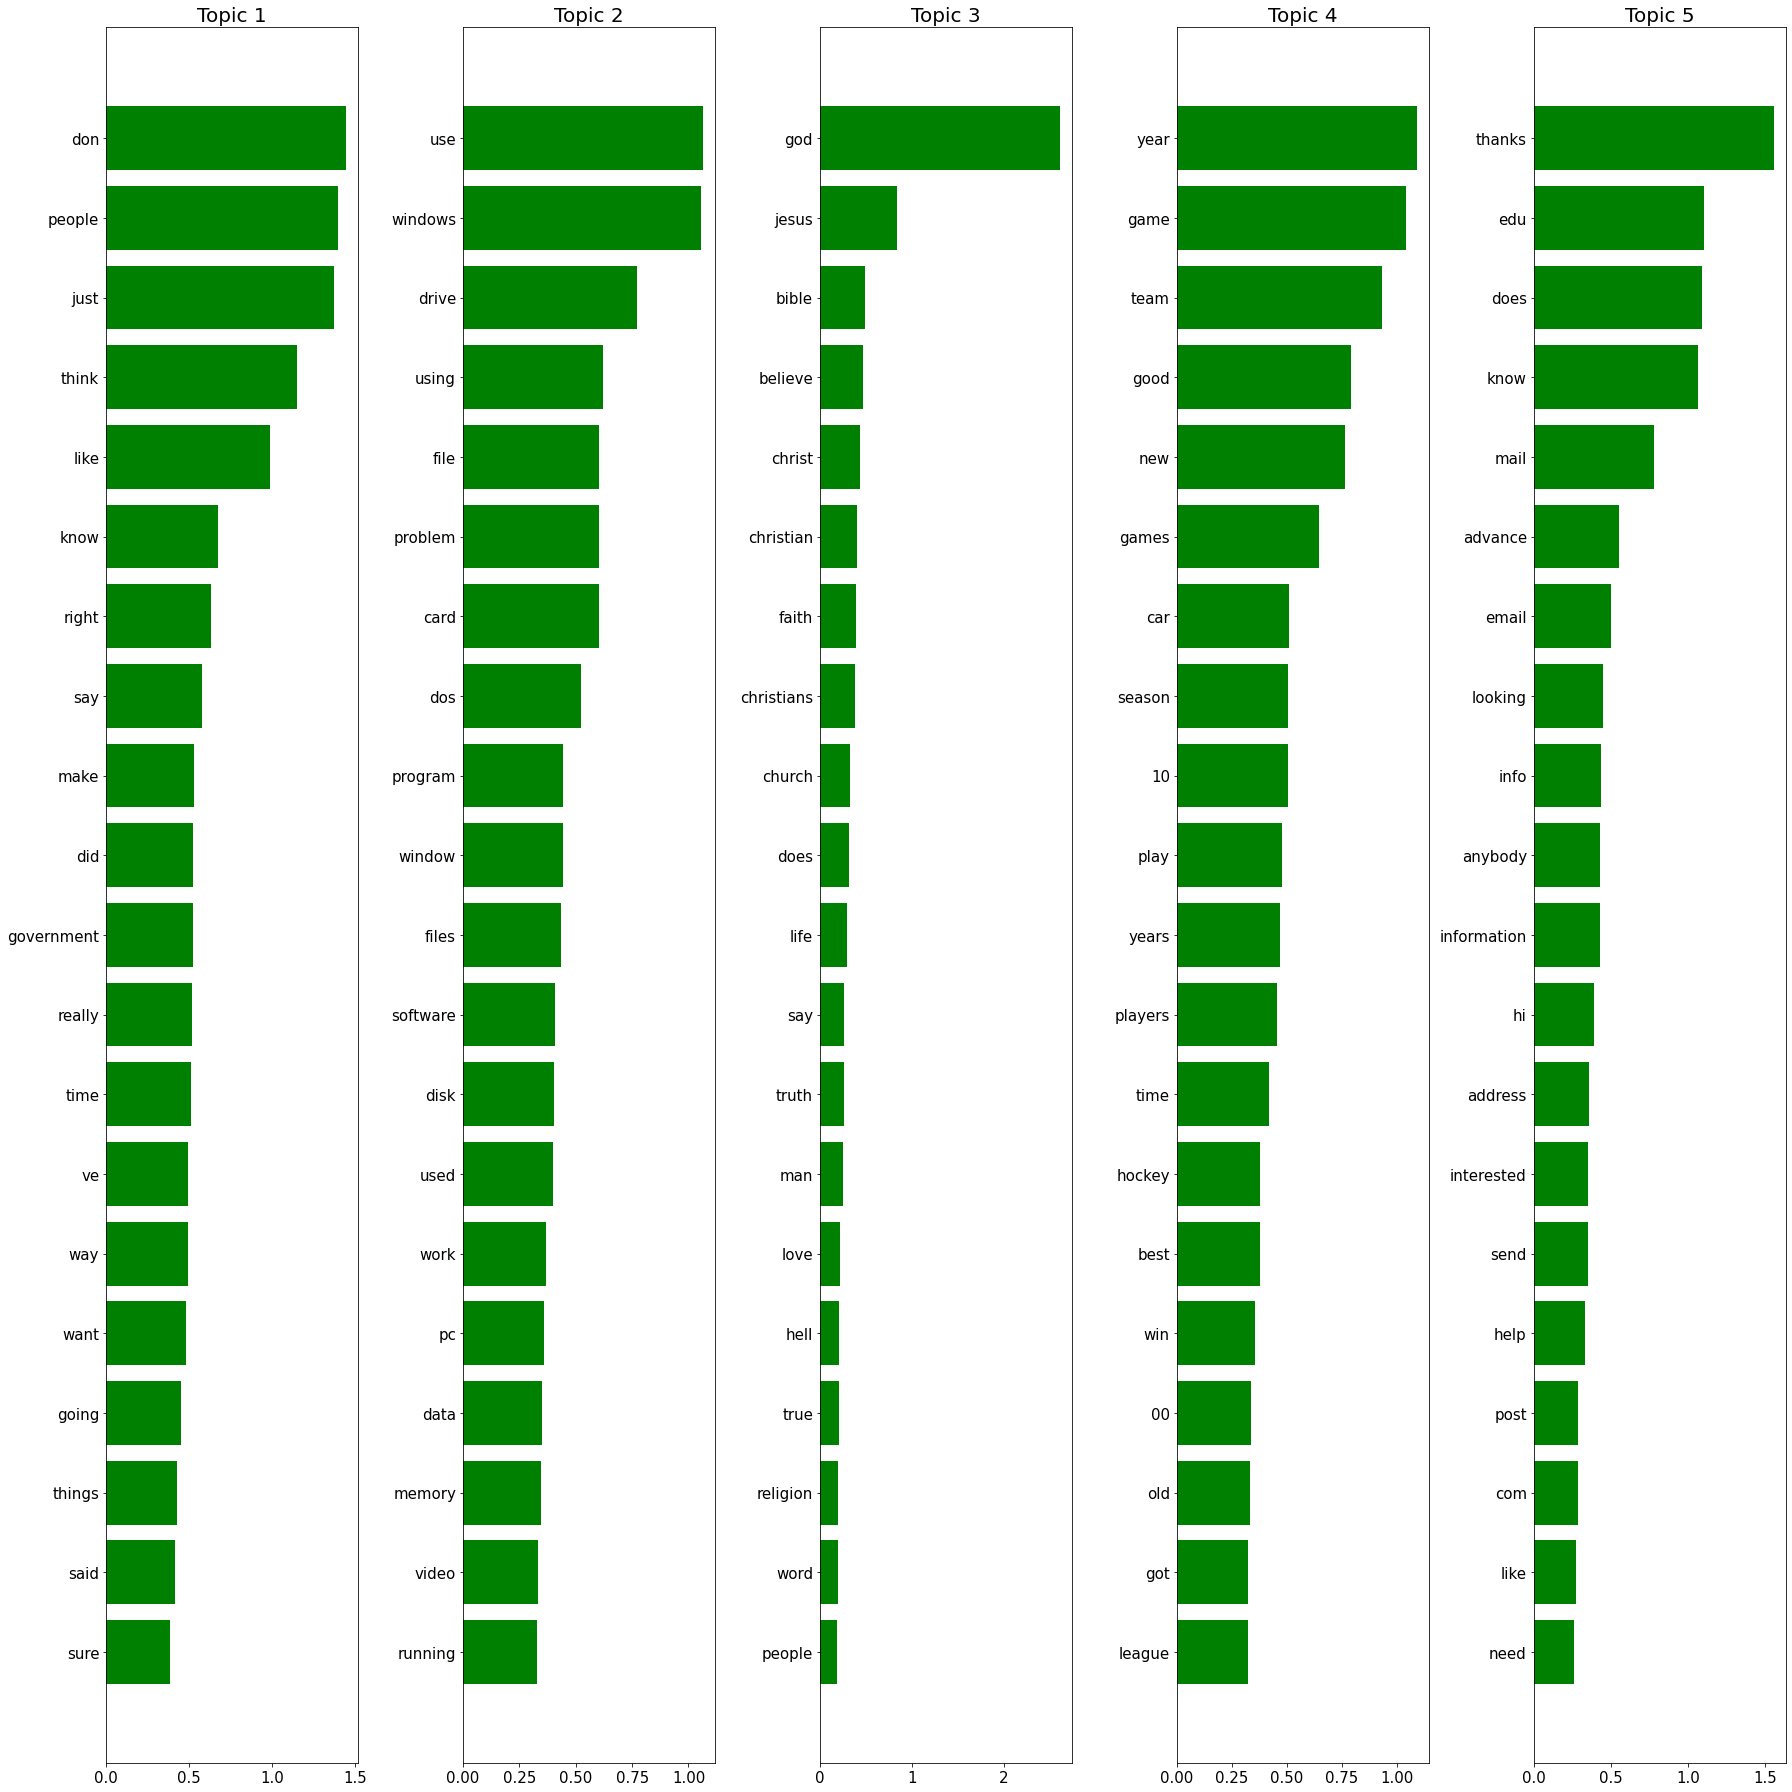

In [39]:
# Define function for plotting top 20 words for each topic
def plot_words_for_topics(n_comp, nmf, feature_names):
  fig, axes = plt.subplots(((n_comp-1)//5)+1, 5, figsize=(25, 25))
  axes = axes.flatten()

  for num_topic, topic in enumerate(nmf.components_, start=1):

    # Plot only the top 20 words

    # Get the top 20 indexes (starting from the most important index)
    top_indexes = np.flip(topic.argsort())[:20]

    # Get the corresponding feature name
    top_features = [feature_names[i] for i in top_indexes]

    # Get the importance of each word
    importance = topic[top_indexes]

    # Plot a barplot
    ax = axes[num_topic-1]
    ax.barh(top_features, importance, color="green")
    ax.set_title(f"Topic {num_topic}", {"fontsize": 20})
    ax.invert_yaxis()
    ax.tick_params(labelsize=15)

  plt.tight_layout()
  plt.show()

# Run the function
plot_words_for_topics(n_comp, nmf, feature_names)

Let's try to summarize each topic based on the top most common words for each one:

- The first topic is hard to describe but seems to be related to people and actions. 

- The second one is clearly abouth tech stuff.

- Third one is about religion.

- Fourth one seems to revolve around sports and/or games.

- And the fifth one about education and/or information.


This makes sense considering the example with the first element of the text data. That text is mostly about cars (sports) and information.

Pretty cool, right?


The following function condenses the previously used code so you can play trying out with different number of components:

In [41]:
def try_nmf(n_comp):
  nmf = NMF(n_components=n_comp, random_state=42)
  nmf.fit(vect_data)
  feature_names = vectorizer.get_feature_names()
  plot_words_for_topics(n_comp, nmf, feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


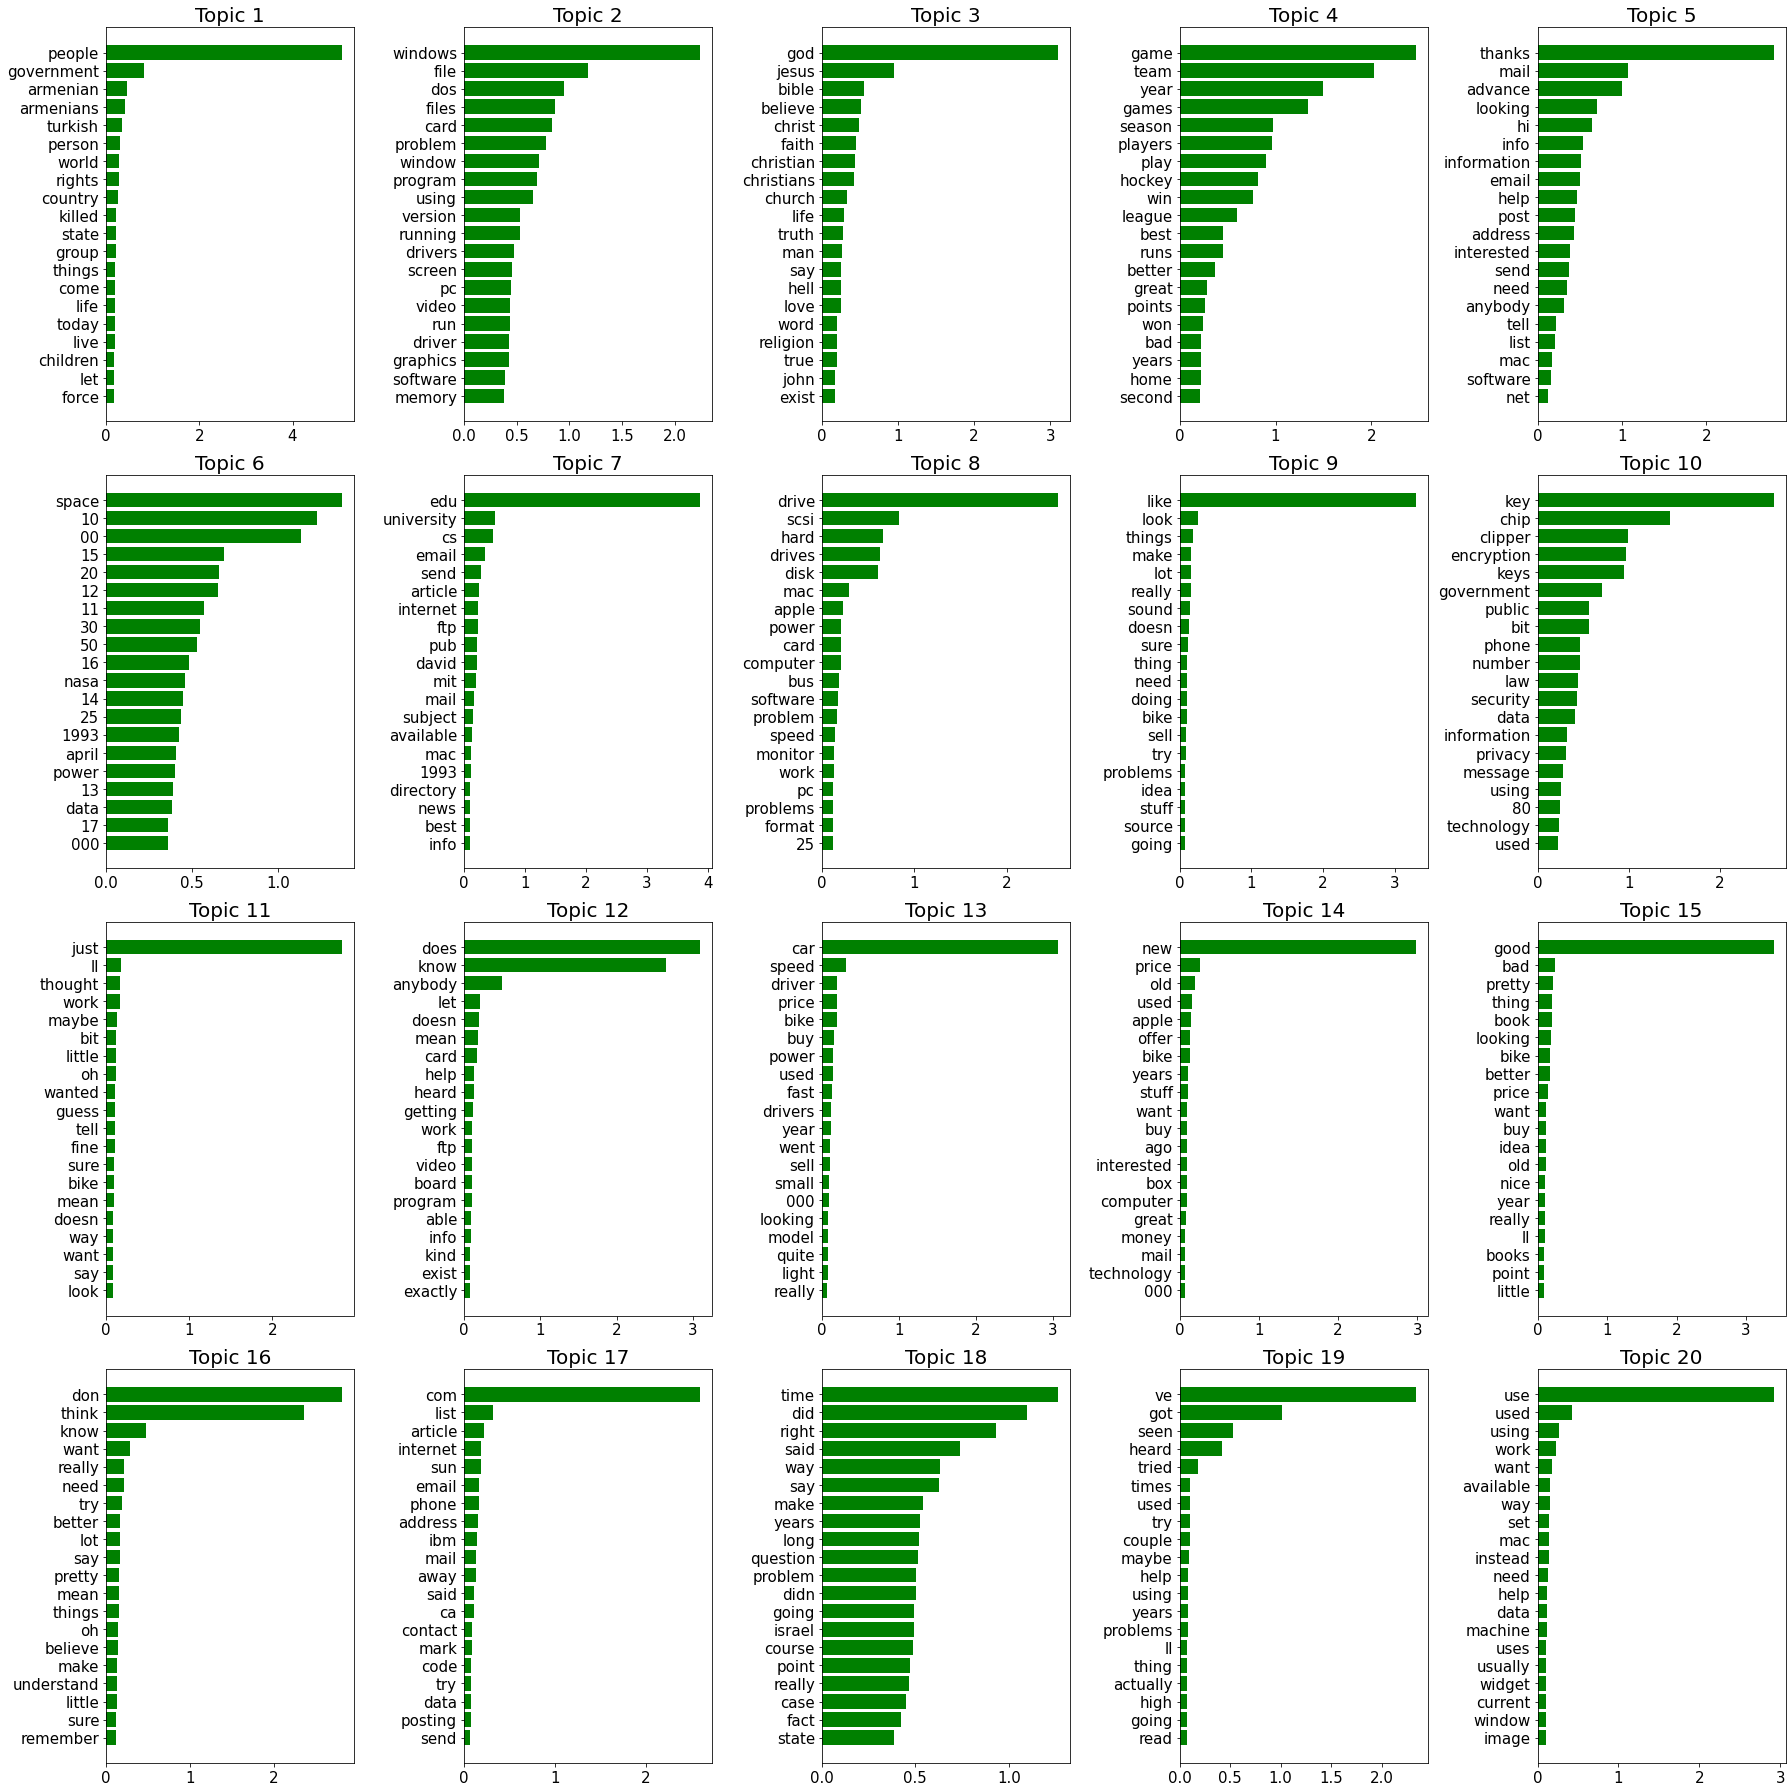

In [42]:
# Try different values!
try_nmf(20)

**Congratulations on finishing this ungraded lab!** 

Now you should have a clearer understanding of how to implement dimensionality reduction techniques. 

The great thing about dimensionality reduction algorithms is that aside from making training and predicting faster, they perform some kind of automatic feature engineering by transforming the raw data into more meaningful representations.


**Keep it up!**